# Урок 11. Модель Transformer-1

Разобраться с моделью перевода (с механизмом внимания) как она устроена, запустить для перевода с русского на английский (при желании можно взять другие пары языков).

In [16]:
# !wget http://www.manythings.org/anki/rus-eng.zip
# !mkdir rus-eng
# !unzip rus-eng.zip -d rus-eng/

In [17]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

def preprocess_sentence(w):
  w = w.lower().strip()

  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  w = '<start> ' + w + ' <end>'
  return w

def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [18]:
path_to_file = "rus-eng/rus.txt"

In [19]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [20]:
en, ru = create_dataset(path_to_file, None)
print(en[-1])
print(ru[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с уч том миллионов живущих на земле людей , ни один подходящи

In [21]:
len(en), len(ru)

(479223, 479223)

In [22]:
num_examples = 200000 # Ограничиваем размер датасета для ускорения обучения
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [23]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

160000 160000 40000 40000


In [24]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
15 ----> у
17 ----> меня
351 ----> хорошая
2918 ----> квартира
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> i
22 ----> have
9 ----> a
381 ----> nice
1186 ----> apartment
3 ----> .
2 ----> <end>


In [25]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

2023-11-04 14:48:12.741864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15406 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:a1:00.0, compute capability: 6.0


In [26]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 12]))

## Encoder

In [27]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [28]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

#инициализируем начальное скрытое состояние из нулей
sample_hidden = encoder.initialize_hidden_state()

#получаем выход энкодера и последнее скрытое состояние
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


2023-11-04 14:48:13.295918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905


In [29]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)

    # применяем к векторам скрытого состояния и выходов энкодера полносвязный слой (выход (batch_size, 1, units) и (batch_size, max_length, units))
    # складываем полученные векторы, применяем к сумму тангенс (batch_size, max_length, units)
    # проводим результат через dense слой (batch_size, max_length, 1)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    # получаем вероятностное распределение
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    # умножаем веса внимания на векторы значенй выход (batch_size, max_len, hidden size)
    context_vector = attention_weights * values
    # находим вдоль столбцов (batch_size, hidden_size)
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [30]:
#создаем слой внимания
attention_layer = BahdanauAttention(10)
#передаем выход энкодера и его скрытое состояние
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


## Decoder

In [31]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # используем слой внимания
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    # получаем выходы слоя внимания (из скрытого состояния и выхода энкодера)
    # context_vector shape == (batch_size, hidden_size)
    # attention_weights shape == (batch_size, max_len, 1)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    #соединяем выход эмбеддинга с вектором контекста и подаем навход RNN
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [32]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
#применяем декодер к случайному батчу из равномерного распределения (батч,1) и выходам энкодера
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 10316)


In [33]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [34]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [35]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    #получаем выходы encoder
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    #помещаем выходное скрытое состояние энкодера в скрытое состояние decoder
    dec_hidden = enc_hidden

    #формируем вход декодера:
    # берем список длины батч из индексов тега 
    # приписываем списку размерность 1
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    #Teacher forcing - выводим target в качестве следующего входа
    for t in range(1, targ.shape[1]):
      #помещаем enc_output, dec_input, dec_hidden в decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      # считаем функцию потерь
      loss += loss_function(targ[:, t], predictions)

      # используем teacher forcing (приписываем списку размерность 1)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  #вычисляем градиенты loss по variables
  gradients = tape.gradient(loss, variables)

  #оптимизатор применяет подсчитанные градиенты
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [36]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  #инициализируем входное скрытое состояние (из нулей) размера (батч, кол-во рекуррентных ячеек)
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    #делаем шаг обучения и считаем ошибку
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  #сохраняем checkpoint каждые 25 эпох
  if (epoch + 1) % 25 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

2023-11-04 14:48:23.237945: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0314145d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-04 14:48:23.237996: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-11-04 14:48:23.251284: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-04 14:48:23.430759: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1 Batch 0 Loss 4.9939
Epoch 1 Batch 100 Loss 2.1782
Epoch 1 Batch 200 Loss 2.1514
Epoch 1 Batch 300 Loss 1.8102
Epoch 1 Batch 400 Loss 1.7834
Epoch 1 Batch 500 Loss 1.7076
Epoch 1 Batch 600 Loss 1.5803
Epoch 1 Batch 700 Loss 1.5541
Epoch 1 Batch 800 Loss 1.4349
Epoch 1 Batch 900 Loss 1.3519
Epoch 1 Batch 1000 Loss 1.3739
Epoch 1 Batch 1100 Loss 1.1072
Epoch 1 Batch 1200 Loss 1.2607
Epoch 1 Batch 1300 Loss 1.1246
Epoch 1 Batch 1400 Loss 0.9899
Epoch 1 Batch 1500 Loss 1.0838
Epoch 1 Batch 1600 Loss 0.9103
Epoch 1 Batch 1700 Loss 0.9883
Epoch 1 Batch 1800 Loss 0.9719
Epoch 1 Batch 1900 Loss 0.8219
Epoch 1 Batch 2000 Loss 0.7865
Epoch 1 Batch 2100 Loss 0.7370
Epoch 1 Batch 2200 Loss 0.7156
Epoch 1 Batch 2300 Loss 0.6850
Epoch 1 Batch 2400 Loss 0.6432
Epoch 1 Loss 1.2950
Time taken for 1 epoch 181.63008856773376 sec

Epoch 2 Batch 0 Loss 0.6711
Epoch 2 Batch 100 Loss 0.5861
Epoch 2 Batch 200 Loss 0.6307
Epoch 2 Batch 300 Loss 0.5366
Epoch 2 Batch 400 Loss 0.5464
Epoch 2 Batch 500 Loss

In [37]:
def evaluate(sentence):
  # строим матрицу внимания из нулей размера (макс длина таргета, макс длина входа)  
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  # выполняем препроцессинг предложений
  sentence = preprocess_sentence(sentence)

  # разбиваем предложение по пробелам и составляем список индексов каждого слова
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  # дополняем inputs нулями справа до максимальной длины входного текста
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  # преобразуем inputs в тензор
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  # инициализируем входной hidden из нулей размера (1, units)
  hidden = [tf.zeros((1, units))]
  # подаем inputs и hidden в encoder
  enc_out, enc_hidden = encoder(inputs, hidden)

  # инициализируем входной hidden декодера -- выходной хидден энкодера
  dec_hidden = enc_hidden
  # вход декодера -- список [индекс start] размера(1,1)
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    # получаем выход декодера
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # сохраняем веса внимания, чтобы позже визуализировать
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    # заканчиваем на токене end
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # предсказанный predicted ID подаем обратно в декодер (размер (1,1))
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [38]:
def plot_attention(attention, sentence, predicted_sentence):
  """функция визуализации"""
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [39]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Переводы и визуализация

In [40]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> отличная погода ! <end>
Predicted translation: great weather ! <end> 


/tmp/ipykernel_101/340526640.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_101/340526640.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


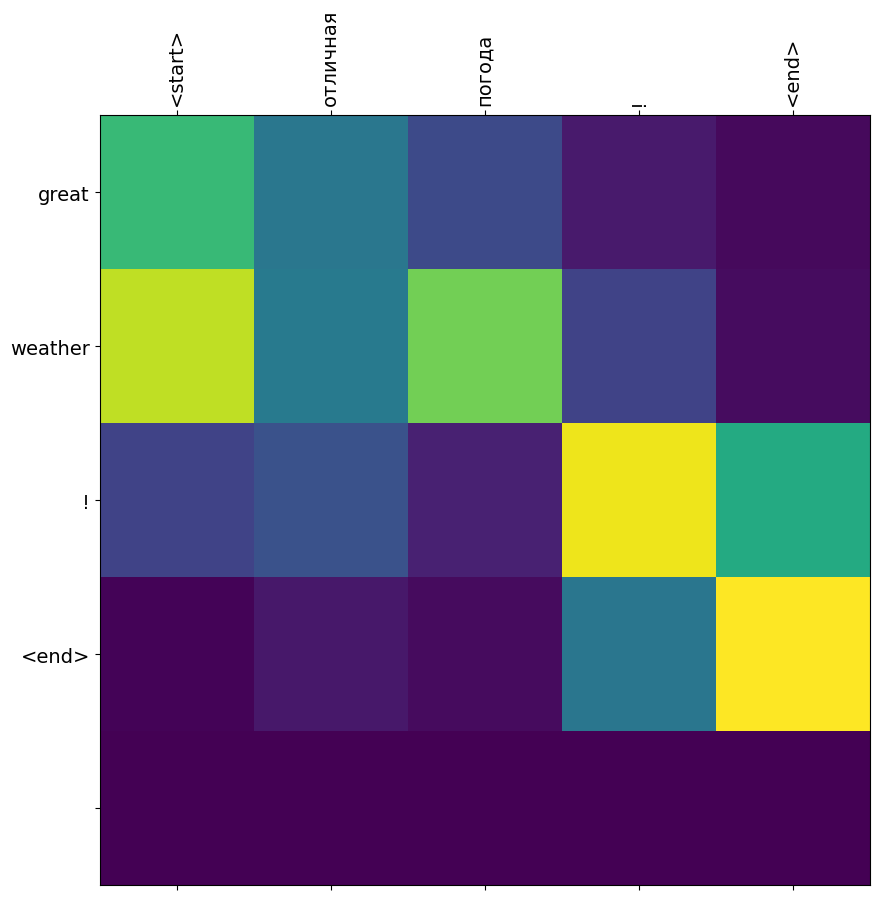

In [41]:
translate('Отличная погода!')

Input: <start> что ещ можно сказать ? <end>
Predicted translation: what more can be said ? <end> 


/tmp/ipykernel_101/340526640.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_101/340526640.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


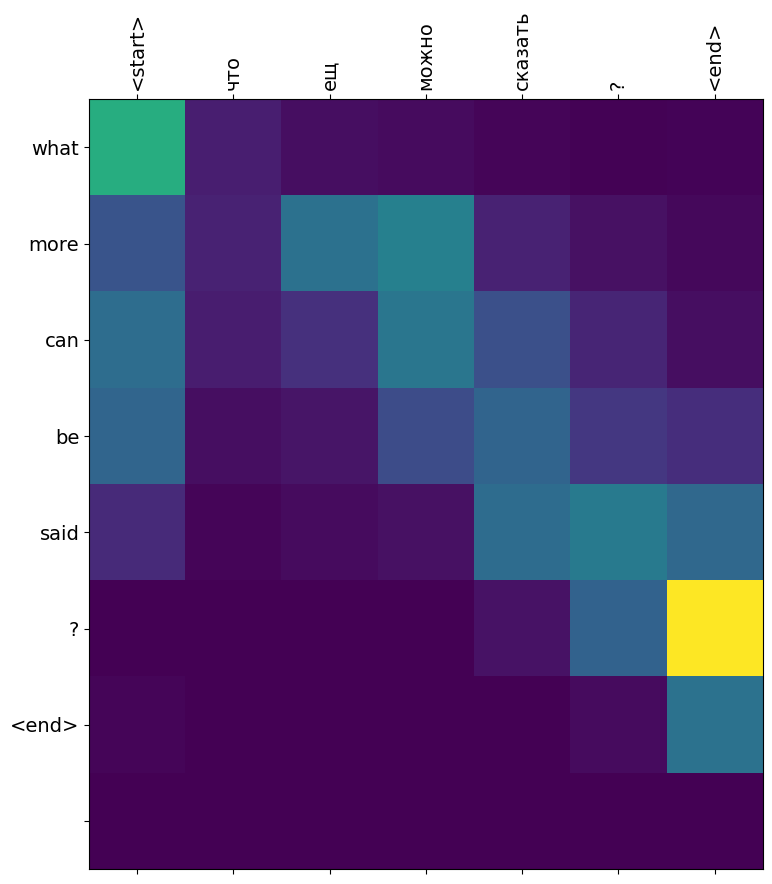

In [42]:
translate('Что ещё можно сказать?')